In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss

# 메트플로립세팅
plt.rc('font', family='malgun gothic')
plt.rc('axes', unicode_minus=False)
%matplotlib inline

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer  # still experimental 
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, PowerTransformer 
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from category_encoders import TargetEncoder  # scikit-learn과 호환됨
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn import set_config

import optuna

## 이상치 제거 함수

In [3]:
def get_outlier(df=None, column=None, weight=1.5):
    import numpy as np
    age_group_list = [20,30,40,50,60,70]
    outlier_index_set = set()
    
    
    for age_group in age_group_list:
        # fraud에 해당하는 column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함. 
        fraud = df[df['연령대_1']==age_group][column]
        quantile_25 = np.percentile(fraud.values, 25)
        quantile_75 = np.percentile(fraud.values, 75)
        iqr = quantile_75 - quantile_25
        iqr_weight = iqr * weight
        lowest_val = quantile_25 - iqr_weight
        highest_val = quantile_75 + iqr_weight
        # 최대값 보다 크거나, 최소값 보다 작은 값을 아웃라이어로 설정하고 DataFrame index 반환. 
        outlier_index_set = outlier_index_set | set(fraud[(fraud < lowest_val) | (fraud > highest_val)].index)
        
    return outlier_index_set

def remove_outlier(df=None,column_list=None,weight=1.5):
    df_copy = df.copy()
    outlier_index_set = set()
    
    for column_name in column_list:
        outlier_index = get_outlier(df=df_copy, column=column_name, weight=weight)
        outlier_index_set = outlier_index_set | set(outlier_index)
    
    df_copy.drop(list(outlier_index_set),inplace=True)
    
    return df_copy[column_list]
    

## 통신데이터 컬럼 드랍 및 데이터 프레임 만들기

In [4]:
for m in tqdm(range(1,10),desc='월단위 진행'):
    globals()["ts{}".format(m)] = pd.read_csv(f'./data/2022.{m}월_29개 통신정보.csv',encoding='cp949')
    try : 
        globals()["ts{}".format(m)].drop(columns=['행정동코드','행정동','총인구수','1인가구수'],inplace=True)    
    except:
        globals()["ts{}".format(m)].drop(columns=['행정동코드','행정동명','총인구','1인가구수'],inplace=True)  
    globals()["ts{}".format(m)].drop(columns=globals()["ts{}".format(m)].filter(like='4분위수'),inplace=True)
    globals()["ts{}".format(m)].drop(columns=globals()["ts{}".format(m)].filter(like='인구'),inplace=True) #미추정
    
    # 데이터가 평균값을 제시하고 그 외 4분위 관련 수치를 따로 제공해주고 있음 -> 이미 전처리가 되어있는 거 같음..?
    globals()["ts{}".format(m)]['연령대_1'] = globals()["ts{}".format(m)]['연령대']//10*10
    globals()["ts{}".format(m)]['월'] = int(m)
    fix = globals()["ts{}".format(m)][['월','연령대','연령대_1','자치구','성별']]
    uni = ['상주지','출근','근무','소액결재','연체','카카오톡','SNS','통화','문자','데이터','이동','체류','지하철','게임','금융','쇼핑','동영상','유튜브','넷플릭스','배달']
    
    for col in tqdm(uni,desc=f'{m}월'):
        globals()["{}_{}".format(col,m)] = pd.concat([fix,globals()["ts{}".format(m)].filter(like=col)],axis=1)    
        
        
for col in tqdm(uni,desc='카테고리별로 합치기'):
    globals()["{}".format(col)] = pd.DataFrame()
    for m in range(1,10):
        globals()["이동_{}".format(m)].drop(columns= globals()["이동_{}".format(m)].filter(like='지하철'),inplace=True)
        globals()["{}".format(col)]= pd.concat([globals()["{}".format(col)],globals()["{}_{}".format(col,m)]])

월단위 진행:   0%|          | 0/9 [00:00<?, ?it/s]

1월:   0%|          | 0/20 [00:00<?, ?it/s]

2월:   0%|          | 0/20 [00:00<?, ?it/s]

3월:   0%|          | 0/20 [00:00<?, ?it/s]

4월:   0%|          | 0/20 [00:00<?, ?it/s]

5월:   0%|          | 0/20 [00:00<?, ?it/s]

6월:   0%|          | 0/20 [00:00<?, ?it/s]

7월:   0%|          | 0/20 [00:00<?, ?it/s]

8월:   0%|          | 0/20 [00:00<?, ?it/s]

9월:   0%|          | 0/20 [00:00<?, ?it/s]

카테고리별로 합치기:   0%|          | 0/20 [00:00<?, ?it/s]

In [5]:
df = pd.concat([ts1,ts2,ts3,ts4,ts5,ts6,ts7,ts8,ts9],axis=0,ignore_index=True)

df

,자치구,성별,연령대,야간상주지 변경횟수 평균,주간상주지 변경횟수 평균,평균 출근 소요시간 평균,평균 근무시간 평균,소액결재 사용횟수 평균,소액결재 사용금액 평균,최근 3개월 내 요금 연체 비율,...,금융 서비스 사용일수,쇼핑 서비스 사용일수,동영상/방송 서비스 사용일수,유튜브 사용일수,넷플릭스 사용일수,배달 서비스 사용일수,배달_브랜드 서비스 사용일수,배달_식재료 서비스 사용일수,연령대_1,월
0,종로구,1,20,2.6,3.8,56.6,514.9,1.7,7333.3,4.81,...,82.8,72.1,28.0,0.3,-0.1,10.3,2.5,1.7,20,1
1,종로구,1,25,2.3,3.7,50.3,527.0,2.3,9486.1,12.50,...,109.3,103.6,31.2,0.2,-0.1,13.9,3.0,1.7,20,1
2,종로구,1,30,2.2,3.1,57.4,532.4,2.7,7071.4,9.88,...,130.2,121.7,30.1,0.1,-0.1,13.8,3.2,1.7,30,1
3,종로구,1,35,2.0,2.7,61.6,540.8,2.4,7072.9,11.95,...,123.2,121.4,28.1,0.1,-0.2,11.2,3.3,1.7,30,1
4,종로구,1,40,1.9,2.6,69.3,554.7,2.8,5655.2,4.62,...,122.2,118.0,28.9,0.0,-0.2,9.3,3.1,1.7,40,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91579,강동구,2,55,1.5,2.7,56.7,502.5,2.3,6623.8,6.68,...,61.5,96.0,15.1,-0.1,-0.6,9.6,3.6,1.7,50,9
91580,강동구,2,60,1.5,2.8,60.8,486.8,2.6,6711.4,6.55,...,45.5,68.0,13.9,-0.1,-0.6,8.9,3.6,1.7,60,9
91581,강동구,2,65,1.4,2.8,60.1,451.1,2.7,6420.3,3.86,...,36.6,52.6,12.5,-0.2,-0.6,7.6,4.2,1.7,60,9
91582,강동구,2,70,1.3,1.4,20.0,520.0,2.8,7051.3,4.49,...,26.2,36.4,10.2,-0.3,-0.6,5.2,0.0,1.7,70,9


In [6]:
col_lst = df.columns[5:]
col_= [x for x in col_lst ]
col_

['평균 출근 소요시간 평균',
 '평균 근무시간 평균',
 '소액결재 사용횟수 평균',
 '소액결재 사용금액 평균',
 '최근 3개월 내 요금 연체 비율',
 'SNS 사용횟수',
 '평균 통화량',
 '평균 문자량',
 '평균 통화대상자 수',
 '평균 문자대상자 수',
 '데이터 사용량',
 '평일 총 이동 횟수',
 '휴일 총 이동 횟수 평균',
 '집 추정 위치 평일 총 체류시간',
 '집 추정 위치 휴일 총 체류시간',
 '평일 총 이동 거리 합계',
 '휴일 총 이동 거리 합계',
 '지하철이동일수 합계',
 '게임 서비스 사용일수',
 '금융 서비스 사용일수',
 '쇼핑 서비스 사용일수',
 '동영상/방송 서비스 사용일수',
 '유튜브 사용일수',
 '넷플릭스 사용일수',
 '배달 서비스 사용일수',
 '배달_브랜드 서비스 사용일수',
 '배달_식재료 서비스 사용일수',
 '연령대_1',
 '월']

In [7]:
# df = remove_outlier(df, column_list=['평균 문자량', '평균 통화량', '평균 통화대상자 수', '평균 문자대상자 수', '평일 총 이동 횟수', '휴일 총 이동 횟수 평균'
#                                     ,'평일 총 이동 거리 합계', '휴일 총 이동 거리 합계', '지하철이동일수 합계'], weight=1.5)

In [8]:
df

,자치구,성별,연령대,야간상주지 변경횟수 평균,주간상주지 변경횟수 평균,평균 출근 소요시간 평균,평균 근무시간 평균,소액결재 사용횟수 평균,소액결재 사용금액 평균,최근 3개월 내 요금 연체 비율,...,금융 서비스 사용일수,쇼핑 서비스 사용일수,동영상/방송 서비스 사용일수,유튜브 사용일수,넷플릭스 사용일수,배달 서비스 사용일수,배달_브랜드 서비스 사용일수,배달_식재료 서비스 사용일수,연령대_1,월
0,종로구,1,20,2.6,3.8,56.6,514.9,1.7,7333.3,4.81,...,82.8,72.1,28.0,0.3,-0.1,10.3,2.5,1.7,20,1
1,종로구,1,25,2.3,3.7,50.3,527.0,2.3,9486.1,12.50,...,109.3,103.6,31.2,0.2,-0.1,13.9,3.0,1.7,20,1
2,종로구,1,30,2.2,3.1,57.4,532.4,2.7,7071.4,9.88,...,130.2,121.7,30.1,0.1,-0.1,13.8,3.2,1.7,30,1
3,종로구,1,35,2.0,2.7,61.6,540.8,2.4,7072.9,11.95,...,123.2,121.4,28.1,0.1,-0.2,11.2,3.3,1.7,30,1
4,종로구,1,40,1.9,2.6,69.3,554.7,2.8,5655.2,4.62,...,122.2,118.0,28.9,0.0,-0.2,9.3,3.1,1.7,40,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91579,강동구,2,55,1.5,2.7,56.7,502.5,2.3,6623.8,6.68,...,61.5,96.0,15.1,-0.1,-0.6,9.6,3.6,1.7,50,9
91580,강동구,2,60,1.5,2.8,60.8,486.8,2.6,6711.4,6.55,...,45.5,68.0,13.9,-0.1,-0.6,8.9,3.6,1.7,60,9
91581,강동구,2,65,1.4,2.8,60.1,451.1,2.7,6420.3,3.86,...,36.6,52.6,12.5,-0.2,-0.6,7.6,4.2,1.7,60,9
91582,강동구,2,70,1.3,1.4,20.0,520.0,2.8,7051.3,4.49,...,26.2,36.4,10.2,-0.3,-0.6,5.2,0.0,1.7,70,9


In [9]:
# 데이터셋 확인을 위한 써머리 함수
def resumetable(df):
    print(f'데이터셋 확인: {df.shape}')
    summary = pd.DataFrame(df.dtypes, columns=['데이터 타입'])
    summary = summary.reset_index()
    summary = summary.rename(columns={'index':'피처'})
    summary['결측치'] = df.isnull().sum().values
    summary['범주'] = df.nunique().values
    summary['1st_value'] = df.iloc[0].values
    summary['2nd_value'] = df.iloc[1].values
    summary['3rd_value'] = df.iloc[2].values
    summary['4th_value'] = df.iloc[3].values
    summary['5th_value'] = df.iloc[4].values
    
    return summary

In [10]:
resumetable(df)

데이터셋 확인: (91584, 34)


,피처,데이터 타입,결측치,범주,1st_value,2nd_value,3rd_value,4th_value,5th_value
0,자치구,object,0,25,종로구,종로구,종로구,종로구,종로구
1,성별,int64,0,2,1,1,1,1,1
2,연령대,int64,0,12,20,25,30,35,40
3,야간상주지 변경횟수 평균,float64,0,29,2.6,2.3,2.2,2.0,1.9
4,주간상주지 변경횟수 평균,float64,0,42,3.8,3.7,3.1,2.7,2.6
5,평균 출근 소요시간 평균,float64,0,692,56.6,50.3,57.4,61.6,69.3
6,평균 근무시간 평균,float64,0,2267,514.9,527.0,532.4,540.8,554.7
7,소액결재 사용횟수 평균,float64,0,18,1.7,2.3,2.7,2.4,2.8
8,소액결재 사용금액 평균,float64,0,29114,7333.3,9486.1,7071.4,7072.9,5655.2
9,최근 3개월 내 요금 연체 비율,float64,0,3029,4.81,12.5,9.88,11.95,4.62


## Pipeline: chaining estimators   
- Pipeline can be used to chain multiple estimators into one.
- 파이프라인을 사용하여 여러 estimator를 하나로 연결할 수 있습니다.

- Pipeline serves two purposes:
- 파이프라인은 두 가지 용도로 사용된다.

  - Convenience and encapsulation
  - 편의성 및 캡슐화
  
  - Joint parameter selection
  - 사용되는 파라미터를 선택할 수 있다.
  
- All estimators in a pipeline, except the last one, must be transformers.
- 파이프라인의 모든 estimators는 마지막 것을 제외하고 transformers여야 합니다.

  - The last estimator may be any type (transformer, classifier, etc.)
  - 마지막 추정기는 모든 유형(transformer, classifier 등)이 될 수 있습니다.
  
- Training and prediction procedure of the pipeline
- 파이프라인의 학습 및 예측 절차

<img align="left" src="http://drive.google.com/uc?export=view&id=1pIde-P6d7EnjL3xYo8eE3cWAUEvzV7tS" >

- Dimensionality Reduction : 차원감소

<font color="#CC3D3D"><p>
# Building a `LightGBM` Model with `Pipeline+Optuna`

In [11]:
LGBM_VERSION = 1.0   # submission 

In [12]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer 
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error
from sklearn import set_config
from lightgbm import LGBMRegressor
from lightgbm import LGBMClassifier
import lightgbm as lgb
import optuna
from optuna.distributions import CategoricalDistribution, IntDistribution, FloatDistribution
from optuna.integration import OptunaSearchCV
from optuna.integration.lightgbm import LightGBMTunerCV

#### Split data

In [13]:
target='평균 문자대상자 수'

X = df.copy().drop(columns=target, axis=1)
y = df[target]
y = round(y)
print(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

test_index = X_test.index

0        4.0
1        4.0
2        6.0
3        6.0
4        7.0
        ... 
91579    5.0
91580    4.0
91581    4.0
91582    3.0
91583    2.0
Name: 평균 문자대상자 수, Length: 91584, dtype: float64


In [14]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73267 entries, 10778 to 3333
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   자치구                73267 non-null  object 
 1   성별                 73267 non-null  int64  
 2   연령대                73267 non-null  int64  
 3   야간상주지 변경횟수 평균      73267 non-null  float64
 4   주간상주지 변경횟수 평균      73267 non-null  float64
 5   평균 출근 소요시간 평균      73267 non-null  float64
 6   평균 근무시간 평균         73267 non-null  float64
 7   소액결재 사용횟수 평균       73267 non-null  float64
 8   소액결재 사용금액 평균       73267 non-null  float64
 9   최근 3개월 내 요금 연체 비율  73267 non-null  float64
 10  SNS 사용횟수           73267 non-null  float64
 11  평균 통화량             73267 non-null  float64
 12  평균 문자량             73267 non-null  float64
 13  평균 통화대상자 수         73267 non-null  float64
 14  데이터 사용량            73267 non-null  float64
 15  평일 총 이동 횟수         73267 non-null  float64
 16  휴일 총 이동 횟수 평균      

In [15]:
X_train.head()

,자치구,성별,연령대,야간상주지 변경횟수 평균,주간상주지 변경횟수 평균,평균 출근 소요시간 평균,평균 근무시간 평균,소액결재 사용횟수 평균,소액결재 사용금액 평균,최근 3개월 내 요금 연체 비율,...,금융 서비스 사용일수,쇼핑 서비스 사용일수,동영상/방송 서비스 사용일수,유튜브 사용일수,넷플릭스 사용일수,배달 서비스 사용일수,배달_브랜드 서비스 사용일수,배달_식재료 서비스 사용일수,연령대_1,월
10778,중구,1,30,2.1,2.7,56.4,554.7,2.7,5958.7,20.76,...,138.9,134.8,34.0,0.3,-0.1,16.4,3.1,1.7,30,2
1601,광진구,2,45,1.4,2.7,50.4,504.5,2.8,7175.9,9.16,...,80.8,120.1,20.9,-0.1,-0.4,9.1,2.6,1.7,40,1
35324,서대문구,2,60,1.6,2.3,65.4,503.5,2.8,4808.5,14.39,...,38.5,54.2,11.0,-0.2,-0.6,8.8,1.7,1.7,60,4
39254,강남구,2,30,2.0,3.1,49.5,527.8,2.4,7968.9,26.38,...,102.4,147.5,26.7,0.1,-0.1,16.6,3.5,1.7,30,4
6050,강서구,1,30,2.0,2.9,72.6,566.5,2.5,7497.1,10.54,...,144.1,125.2,33.0,0.2,-0.1,13.6,3.1,1.7,30,1


#### 수치형/범주형 피처 분리

In [16]:
X_train.columns

Index(['자치구', '성별', '연령대', '야간상주지 변경횟수 평균', '주간상주지 변경횟수 평균', '평균 출근 소요시간 평균',
       '평균 근무시간 평균', '소액결재 사용횟수 평균', '소액결재 사용금액 평균', '최근 3개월 내 요금 연체 비율',
       'SNS 사용횟수', '평균 통화량', '평균 문자량', '평균 통화대상자 수', '데이터 사용량', '평일 총 이동 횟수',
       '휴일 총 이동 횟수 평균', '집 추정 위치 평일 총 체류시간', '집 추정 위치 휴일 총 체류시간',
       '평일 총 이동 거리 합계', '휴일 총 이동 거리 합계', '지하철이동일수 합계', '게임 서비스 사용일수',
       '금융 서비스 사용일수', '쇼핑 서비스 사용일수', '동영상/방송 서비스 사용일수', '유튜브 사용일수',
       '넷플릭스 사용일수', '배달 서비스 사용일수', '배달_브랜드 서비스 사용일수', '배달_식재료 서비스 사용일수',
       '연령대_1', '월'],
      dtype='object')

In [17]:
df1 = df[['평균 문자대상자 수', '평균 근무시간 평균', '평균 통화대상자 수', '평일 총 이동 거리 합계', '휴일 총 이동 거리 합계','금융 서비스 사용일수', '쇼핑 서비스 사용일수']]

In [18]:
# sns.pairplot(df1)
# plt.savefig('pair.png')

In [19]:
numeric_features = ['평균 근무시간 평균', '평균 통화대상자 수', '평일 총 이동 거리 합계', '휴일 총 이동 거리 합계','금융 서비스 사용일수', '쇼핑 서비스 사용일수']
categorical_features = ['자치구']

X_train = X_train[numeric_features+categorical_features]  # 순서 주의!!!
X_test = X_test[numeric_features+categorical_features]

####  파이프라인 구축 수치형과 범주형 피처를 다르게 처리할 수 있는 ColumnTransformer를 활용

<font color="blue"><p>
#### 모형개발 절차
1. 수치형 피처
 - 결측값처리: SimpleImputer(strategy=mean)
 - 이상값처리: FunctionTransformer(remove_outlier, kw_args={'q':0.05})
 - 스케일링: PowerTransformer()
2. 범주형 피처
 - 결측값처리: SimpleImputer(strategy="most_frequent")
 - 인코딩: OrdinalEncoder(handle_unknown='use_encoded_value')  
3. 공통
 - Column classification : column_transformer
 - Feature Selection: SelectPercentile(percentile=80)
 - Modeling: LGBMRegressor()
 - Hyperparametor Optimization: `OptunaSearchCV`

In [20]:
param_LGBMRegressor = {
    'max_depth' : -1,
    'random_state' : 0,
    'num_leaves' : 31
}

In [21]:
def remove_outlier(X, q=0.05):  
    df = pd.DataFrame(X)
    return df.apply(lambda x: x.clip(x.quantile(q), x.quantile(1-q)), axis=0).values
# 5% 와 95% 의 값들 10% 의 값을 제거하는 간단한 이상치 제거 함수 사용.

# steps: 순차적으로 변환되는(name, transfrom) 튜플의 목록이다. 마지막 transform은 estimator형태여야 한다.

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("outlier", FunctionTransformer(remove_outlier, kw_args={'q':0.05})), 
        ("scaler", PowerTransformer()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")), 
        ("encoder", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, dtype=int)),
    ]
)

column_transformer = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

preprocessor = Pipeline(
    steps=[
        ("column", column_transformer), 
        ("selector", SelectPercentile(percentile=80)),
    ]
)

model = Pipeline(
    steps=[
        ("preprocessor", preprocessor), 
        ("classifier", LGBMRegressor(**param_LGBMRegressor)),
    ]
)

set_config(display="diagram")  # To view the text pipeline, change to display='text'.
model

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('column',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('outlier',
                                                                                    FunctionTransformer(func=<function remove_outlier at 0x000001617CE159D0>,
                                                                                                        kw_args={'q': 0.05})),
                                                                                   ('scaler',
                                                                                    PowerTransformer())]),
                                                                   ['평균 근무시간 '
                                                                    '평균',
                                                                    '평균 통화대상자 '
                                                                    '수',
                                                                    '평일 총 이동 '
                                                                    '거리 합계',
                                                                    '휴일 총 이동 '
                                                                    '거리 합계',
                                                                    '금융 서비스 '
                                                                    '사용일수',
                                                                    '쇼핑 서비스 '
                                                                    '사용일수']),
                                                                  ('cat',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('encoder',
                                                                                    OrdinalEncoder(dtype=<class 'int'>,
                                                                                                   handle_unknown='use_encoded_value',
                                                                                                   unknown_value=-1))]),
                                                                   ['자치구'])])),
                                 ('selector',
                                  SelectPercentile(percentile=80))])),
                ('classifier', LGBMRegressor(random_state=0))])

#### LGBM Baseline 성능 확인

In [22]:
scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=5)

# neg_mean_squared_error

# 손실함수는 정답에 대한 오류를 숫자로 나타내는 것으로 오답에 가까울수록 큰 값이 나온다. 반대로 정답에 가까울수록 작은 값이 나온다.
# neg_mean_squared_error : scoring='neg_mean_squared_error'를 쓰는 이유는 scoring 매개변수에 클수록 좋은 함수를 기대하기 때문에 -mse를 쓰고 나서 나중에 다시 -를 곱해준다.
# 쉽게 말해 100$를 잃는 것보다 15$ 를 잃는 것이 좋기 때문이다.

print("LGBM CV scores: ", np.sqrt(-1*scores))
print("LGBM CV mean = %.2f" % np.sqrt(-1*scores.mean()), "with std = %.2f" % np.sqrt(scores.std()))

LGBM CV scores:  [0.44356136 0.43992642 0.43794345 0.44293461 0.44762576]
LGBM CV mean = 0.44 with std = 0.05


#### LGBM 하이퍼파라미터 최적화
- 1단계) 전처리 파라미터 최적값 탐색: OptunaSearchCV를 통해 전처리 관련 최적의 파라미터을 찾음

In [23]:
%%time

param_distributions = {
    "preprocessor__column__num__imputer__strategy": CategoricalDistribution(["mean","median"]),
    "preprocessor__column__num__outlier__kw_args": CategoricalDistribution([{'q':0.01},{'q':0.05},{'q':0.1}]),
    "preprocessor__selector__percentile": IntDistribution(50,100,step=10),
}

optuna_search = OptunaSearchCV(model, 
                               param_distributions, 
                               cv=5, scoring='neg_mean_squared_error', 
                               n_trials=10,
                               study=optuna.create_study(sampler=optuna.samplers.TPESampler(seed=100), direction="maximize"))

optuna.logging.set_verbosity(optuna.logging.WARNING)
optuna_search.fit(X_train, y_train)

# 최적값으로 파이프라인 재설정
print(f"Best params: {optuna_search.best_params_}")
print("Best score: %.2f" % (-1*optuna_search.best_score_)**0.5)

[I 2022-12-08 14:31:59,506] A new study created in memory with name: no-name-9fd0a8de-9295-4514-95b5-371d722189eb


Best params: {'preprocessor__column__num__imputer__strategy': 'median', 'preprocessor__column__num__outlier__kw_args': {'q': 0.05}, 'preprocessor__selector__percentile': 100}
Best score: 0.42
Wall time: 27.5 s


- 2단계) 전처리 최적화 수행: 최적의 파라미터 값으로 파이프라인 재설정

In [24]:
# 최적값으로 파이프라인 재설정
model.set_params(**optuna_search.best_params_)

# 전처리가 된 파이프라인만 수행한다.
X_train = preprocessor.fit_transform(X_train, y_train)
X_test = preprocessor.transform(X_test)

- 3단계) LGBM 모형 최적화: Optuna의 LightGBMTunerCV을 통한 하이퍼파라미터 최적화

In [25]:
tuner = LightGBMTunerCV(
    params={
        "objective": "regression",   # 지도학습 유형(regression/binary/multiclass)
        "metric": "rmse",
        "verbosity": -1,             # 진행과정 출력안함
        "boosting_type": "gbdt",     # 실행하고자 하는 알고리즘 유형(gdbt/rf/dart/goss)
        "seed": 0,
    },
    train_set=lgb.Dataset(X_train, y_train), # LGBM 데이터셋으로 변환
    nfold=5,
    num_boost_round=200,                     # boosting 반복횟수
    callbacks=[lgb.early_stopping(100)],     # 모든 정지 라운드 동안 validation 성능이 개선되지 않으면 조기종료
    time_budget=60,                          # 튜닝 허용 최대시간(초단위)
    optuna_seed=0,
)

tuner.run()

feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.414843:  14%|######4                                      | 1/7 [00:01<00:08,  1.44s/it]

Did not meet early stopping. Best iteration is:
[200]	cv_agg's rmse: 0.414843 + 0.0020095


feature_fraction, val_score: 0.408276:  29%|############8                                | 2/7 [00:03<00:07,  1.58s/it]

Did not meet early stopping. Best iteration is:
[200]	cv_agg's rmse: 0.408276 + 0.00274645


feature_fraction, val_score: 0.408276:  43%|###################2                         | 3/7 [00:04<00:06,  1.57s/it]

Did not meet early stopping. Best iteration is:
[200]	cv_agg's rmse: 0.408276 + 0.00274645


feature_fraction, val_score: 0.408276:  57%|#########################7                   | 4/7 [00:06<00:04,  1.57s/it]

Did not meet early stopping. Best iteration is:
[200]	cv_agg's rmse: 0.408276 + 0.00274645


feature_fraction, val_score: 0.408276:  71%|################################1            | 5/7 [00:07<00:03,  1.54s/it]

Did not meet early stopping. Best iteration is:
[200]	cv_agg's rmse: 0.408276 + 0.00274645


feature_fraction, val_score: 0.408276:  86%|######################################5      | 6/7 [00:09<00:01,  1.57s/it]

Did not meet early stopping. Best iteration is:
[200]	cv_agg's rmse: 0.408276 + 0.00274645


feature_fraction, val_score: 0.408276: 100%|#############################################| 7/7 [00:10<00:00,  1.56s/it]


Did not meet early stopping. Best iteration is:
[200]	cv_agg's rmse: 0.408276 + 0.00274645


num_leaves, val_score: 0.400566:   5%|##5                                               | 1/20 [00:03<01:11,  3.77s/it]

Did not meet early stopping. Best iteration is:
[166]	cv_agg's rmse: 0.400566 + 0.0023593


num_leaves, val_score: 0.400234:  10%|#####                                             | 2/20 [00:08<01:15,  4.19s/it]

Did not meet early stopping. Best iteration is:
[145]	cv_agg's rmse: 0.400234 + 0.00230722


num_leaves, val_score: 0.400234:  15%|#######5                                          | 3/20 [00:12<01:08,  4.03s/it]

Did not meet early stopping. Best iteration is:
[145]	cv_agg's rmse: 0.400234 + 0.00230722


num_leaves, val_score: 0.400234:  20%|##########                                        | 4/20 [00:15<01:02,  3.90s/it]

Did not meet early stopping. Best iteration is:
[145]	cv_agg's rmse: 0.400234 + 0.00230722


num_leaves, val_score: 0.400234:  25%|############5                                     | 5/20 [00:19<00:55,  3.72s/it]

Did not meet early stopping. Best iteration is:
[145]	cv_agg's rmse: 0.400234 + 0.00230722


num_leaves, val_score: 0.400234:  30%|###############                                   | 6/20 [00:23<00:54,  3.91s/it]

Did not meet early stopping. Best iteration is:
[145]	cv_agg's rmse: 0.400234 + 0.00230722


num_leaves, val_score: 0.400234:  35%|#################5                                | 7/20 [00:26<00:48,  3.74s/it]

Did not meet early stopping. Best iteration is:
[145]	cv_agg's rmse: 0.400234 + 0.00230722


num_leaves, val_score: 0.400113:  40%|####################                              | 8/20 [00:31<00:49,  4.16s/it]

Early stopping, best iteration is:
[87]	cv_agg's rmse: 0.400113 + 0.00256656


num_leaves, val_score: 0.399719:  45%|######################5                           | 9/20 [00:39<00:56,  5.11s/it]

Did not meet early stopping. Best iteration is:
[104]	cv_agg's rmse: 0.399719 + 0.00268269


num_leaves, val_score: 0.399719:  50%|########################5                        | 10/20 [00:42<00:45,  4.52s/it]

Did not meet early stopping. Best iteration is:
[104]	cv_agg's rmse: 0.399719 + 0.00268269


num_leaves, val_score: 0.399719:  55%|##########################9                      | 11/20 [00:43<00:31,  3.53s/it]

Did not meet early stopping. Best iteration is:
[104]	cv_agg's rmse: 0.399719 + 0.00268269


num_leaves, val_score: 0.399632:  60%|#############################4                   | 12/20 [00:49<00:33,  4.16s/it]


Did not meet early stopping. Best iteration is:
[107]	cv_agg's rmse: 0.399632 + 0.00264186


  0%|                                                                                            | 0/5 [00:00<?, ?it/s]


In [26]:
print(f"\nBest params: {tuner.best_params}")
print(f"\nBest score: {tuner.best_score:.2f}")


Best params: {'objective': 'regression', 'metric': 'rmse', 'verbosity': -1, 'boosting_type': 'gbdt', 'seed': 0, 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 253, 'feature_fraction': 1.0, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20}

Best score: 0.40


In [27]:
# 최적화된 하이퍼파라미터로 OOF를 수행하여 최종 LGBM 모형 생성
models = cross_validate(LGBMRegressor(**tuner.best_params), # 최적화된 hyperparameter 사용
                        X_train, y_train, 
                        cv=5, 
                        scoring='neg_mean_squared_error', 
                        return_estimator=True)
oof_pred = np.array([m.predict(X_test) for m in models['estimator']]).mean(axis=0)

scores = models['test_score']
print("\nTuned LGBM CV scores: ", np.sqrt(-1*scores))
print("Tuned LGBM CV mean = %.2f" % np.sqrt(-1*scores.mean()), "with std = %.2f" % np.sqrt(scores.std()))

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=

In [28]:
# file
filename = f'lgbm_{LGBM_VERSION}_{np.sqrt(-1*scores.mean()):.2f}.csv'
pd.DataFrame({'index':test_index, '평균 문자 대상자 수':oof_pred}).to_csv(filename, index=False)

In [29]:
# OOF 앙상블은 KFold 교차 검증에서 생성되는 각 Fold에 대한 예측 값을 앙상블하는 기법으로, 모델 검증과 함께 앙상블을 진행할 수 있다.

# https://steadiness-193.tistory.com/290

In [30]:
r = pd.read_csv('lgbm_1.0_0.47.csv')

In [31]:
r['평균 문자 대상자 수']

0        5.411279
1        4.136904
2        5.078064
3        6.111596
4        6.979644
           ...   
18312    5.987399
18313    5.165789
18314    3.914462
18315    2.618577
18316    4.919216
Name: 평균 문자 대상자 수, Length: 18317, dtype: float64

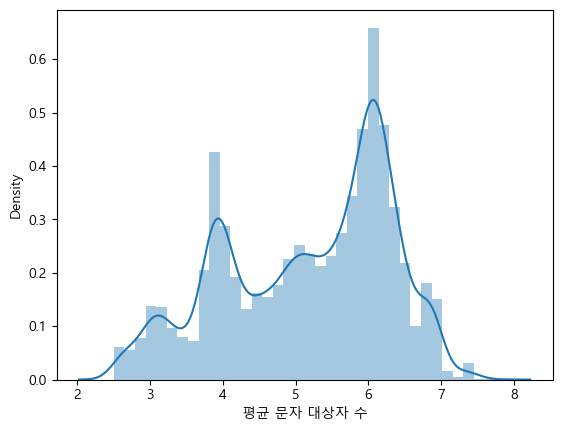

In [32]:
sns.distplot(r['평균 문자 대상자 수']); plt.show()

In [33]:
# df = df[['자치구', '성별', '연령대', '연령대_1', '월', '야간상주지 변경횟수 평균',
#        '주간상주지 변경횟수 평균', '평균 출근 소요시간 평균', '평균 근무시간 평균', '소액결재 사용횟수 평균',
#        '소액결재 사용금액 평균', '최근 3개월 내 요금 연체 비율', 'SNS 사용횟수', '평균 통화량', '평균 문자량',
#        '평균 통화대상자 수', '평균 문자대상자 수', '데이터 사용량', '평일 총 이동 횟수', '휴일 총 이동 횟수 평균',
#        '집 추정 위치 평일 총 체류시간', '집 추정 위치 휴일 총 체류시간', '평일 총 이동 거리 합계',
#        '휴일 총 이동 거리 합계', '지하철이동일수 합계', '게임 서비스 사용일수', '금융 서비스 사용일수',
#        '쇼핑 서비스 사용일수', '동영상/방송 서비스 사용일수', '유튜브 사용일수', '넷플릭스 사용일수',
#        '배달 서비스 사용일수', '배달_브랜드 서비스 사용일수', '배달_식재료 서비스 사용일수']]
# # 사용할 컬럼만 뽑아 쓰세요~

In [34]:
# col_lst = df.columns[5:]
# col_= [x for x in col_lst ]
# col_

In [35]:
# remove_outlier(df,col_)
# df